### Exercise

Multi-label classification of cats and birds.


### Solution

Transfer learning from the MobileNet V2 pre-trained on ImageNet. Code mostly taken from https://www.tensorflow.org/tutorials/images/transfer_learning. 


### Result

Final accuracy on test set: 95.2%.


 

# Imports and constants

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [195]:
!mkdir "/content/dataset/"
!cp -r "/content/gdrive/MyDrive/IntuitiveTechnicalInterview/dataset/" "/content/"

mkdir: cannot create directory ‘/content/dataset/’: File exists
^C


In [238]:
import tensorflow as tf
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [239]:
data_dir='/content/dataset/'
train_dir=data_dir+'training'
test_dir=data_dir+'test'

IMG_SIZE = (128, 128)
BATCH_SIZE = 32

# Load images

In [240]:
# Check if the dataset is balanced
print(len(glob.glob("/content/dataset/training/cats/*.jpeg")))
print(len(glob.glob("/content/dataset/training/birds/*.jpeg")))

5439
5438


In [241]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    batch_size=BATCH_SIZE, 
    image_size=IMG_SIZE, 
    seed=2021, 
    validation_split=0.2, 
    subset="training"
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    batch_size=BATCH_SIZE, 
    image_size=IMG_SIZE, 
    seed=2021, 
    validation_split=0.2, 
    subset="validation"
)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    seed=2021,
    batch_size=BATCH_SIZE, 
    image_size=IMG_SIZE
)

class_names = train_ds.class_names

Found 10877 files belonging to 2 classes.
Using 8702 files for training.
Found 10877 files belonging to 2 classes.
Using 2175 files for validation.
Found 334 files belonging to 2 classes.


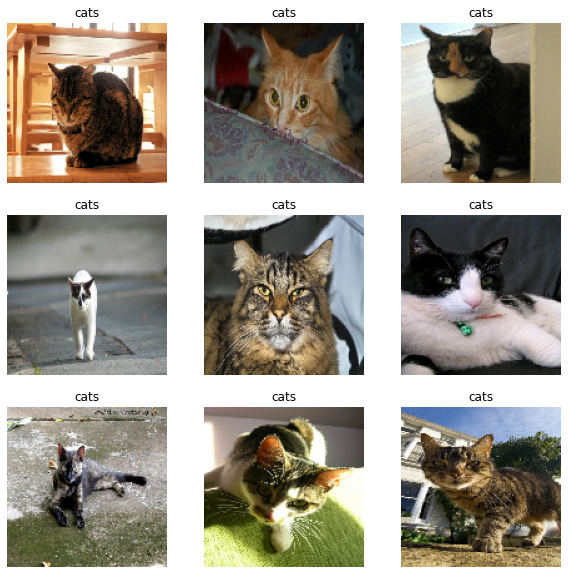

In [242]:
# Display some images
plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [243]:
# The dataset is prefetched to speed up training
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

# Create model

1. Load the MobileNet V2 model pre-trained on ImageNet and freeze its weights for transfer learning.
1. Create model composed of:
  1. Data augmentation: random horizontal flip, random rotation.
  1. MobileNet V2 (with pre-processing to put range of pixel values to [-1, 1].
  1. 2D average to flatten output features of MobileNet V2.
  1. Dropout.
  1. 2 output neurons: birds, cats.






In [244]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False # freeze weights for transfer learning

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

# Create model
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(len(class_names))(x)
model = tf.keras.Model(inputs, outputs)

In [245]:
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 128, 128, 3)]     0         
_________________________________________________________________
sequential_5 (Sequential)    (None, 128, 128, 3)       0         
_________________________________________________________________
tf.math.truediv_5 (TFOpLambd (None, 128, 128, 3)       0         
_________________________________________________________________
tf.math.subtract_5 (TFOpLamb (None, 128, 128, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_128 (Functi (None, 4, 4, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_5 ( (None, 1280)              0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 1280)              0   

# Transfer learning

## Compile and train model

In [246]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

initial_epochs = 10

history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/10
272/272 [==============================] - 38s 128ms/step - loss: 0.6986 - accuracy: 0.6729 - val_loss: 0.1416 - val_accuracy: 0.9664
Epoch 2/10
272/272 [==============================] - 35s 124ms/step - loss: 0.1928 - accuracy: 0.9340 - val_loss: 0.0811 - val_accuracy: 0.9798
Epoch 3/10
272/272 [==============================] - 35s 125ms/step - loss: 0.1374 - accuracy: 0.9500 - val_loss: 0.0656 - val_accuracy: 0.9862
Epoch 4/10
272/272 [==============================] - 35s 125ms/step - loss: 0.1254 - accuracy: 0.9607 - val_loss: 0.0614 - val_accuracy: 0.9876
Epoch 5/10
272/272 [==============================] - 35s 124ms/step - loss: 0.1151 - accuracy: 0.9639 - val_loss: 0.0577 - val_accuracy: 0.9880
Epoch 6/10
272/272 [==============================] - 35s 125ms/step - loss: 0.1141 - accuracy: 0.9639 - val_loss: 0.0563 - val_accuracy: 0.9876
Epoch 7/10
272/272 [==============================] - 35s 125ms/step - loss: 0.1117 - accuracy: 0.9671 - val_loss: 0.0562 - val_ac

## Learning history

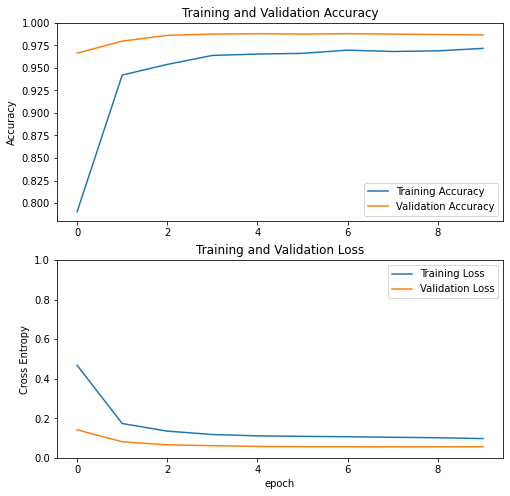

In [247]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Evaluation on test set

In [248]:
# Extract images and labels from tf.Dataset object
images = []
labels = []

for ims, labs in test_ds.as_numpy_iterator():
  images.extend(ims)
  labels.extend(labs)

images = np.array(images)
labels = np.array(labels)

preds = np.argmax(tf.nn.softmax(model.predict(images)), axis=1)

### Accuracy

In [249]:
loss, accuracy = model.evaluate(images, labels)
print('Test accuracy :', accuracy)

11/11 [==============================] - 0s 13ms/step - loss: 0.1552 - accuracy: 0.9521
Test accuracy : 0.9520958065986633


### Precision, recall, F1-score

In [250]:
# The true/false positive/negative for the bird and cat classes
birds_birds = sum(np.logical_and(preds == 0, labels == 0))
cats_birds = sum(np.logical_and(preds == 0, labels == 1))
birds_cats = sum(np.logical_and(preds == 1, labels == 0))
cats_cats = sum(np.logical_and(preds == 1, labels == 1))

# Helper functions
def precision(tp, fp):
  return tp/(tp+fp)
def recall(tp, fn):
  return tp/(tp+fn)
def f1_score(prec, rec):
  return 2*prec*rec/(prec+rec)

birds_precision = precision(birds_birds, cats_birds)
birds_recall = recall(birds_birds, birds_cats)
birds_f1 = f1_score(birds_precision, birds_recall)

cats_precision = precision(cats_cats, birds_cats)
cats_recall = recall(cats_cats, cats_birds)
cats_f1 = f1_score(cats_precision, cats_recall)

print("Precision, recall and F1-score for the bird and cat classes")
pd.DataFrame(np.column_stack([
     [birds_precision, birds_recall, birds_f1], 
     [cats_precision, cats_recall, cats_f1]
     ]), 
     columns=class_names, 
     index=['Precision', 'Recall', 'F1-score']
)

Precision, recall and F1-score for the bird and cat classes


,birds,cats
Precision,0.880435,0.979339
Recall,0.941860,0.955645
F1-score,0.910112,0.967347


### Display misclassified images

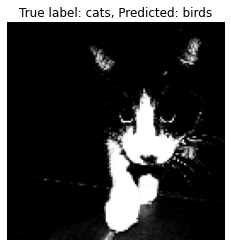

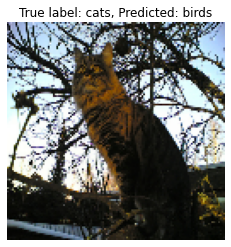

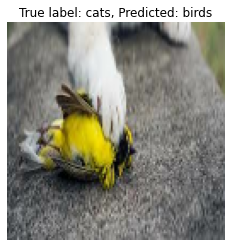

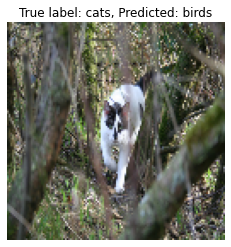

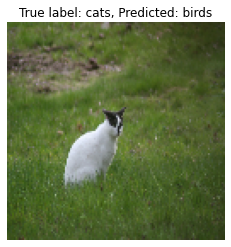

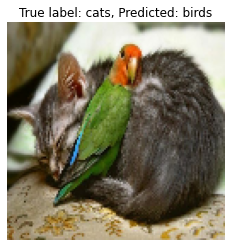

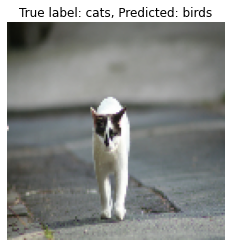

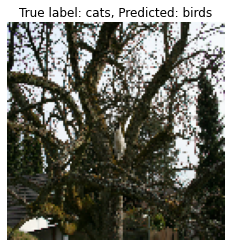

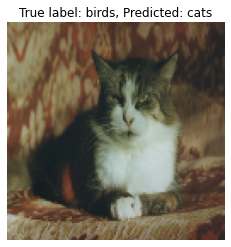

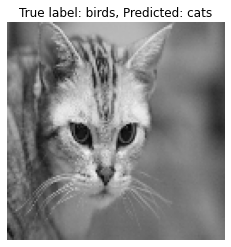

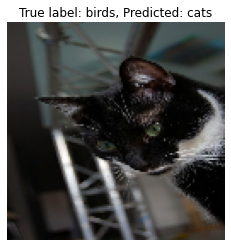

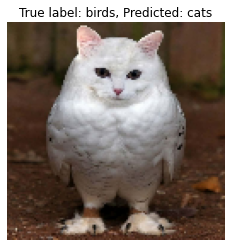

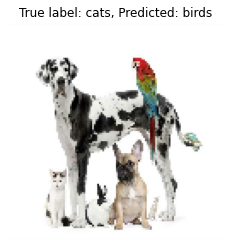

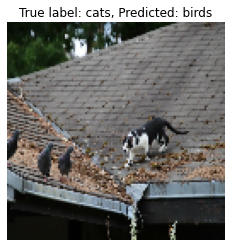

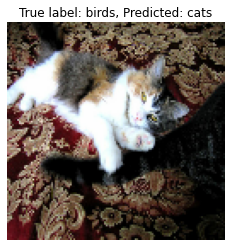

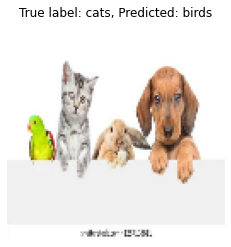

In [251]:
plt.figure()
for id in np.where(preds != labels)[0]:
  plt.imshow(images[id].astype("uint8"))
  plt.title(f"True label: {class_names[labels[id]]}, Predicted: {class_names[preds[id]]}")
  plt.axis("off")
  plt.show()